University of Helsinki, Master's Programme in Data Science  
DATA20047 Probabilistic Cognitive Modelling - Spring 2023  
Luigi Acerbi  

# Week 4 workshop: Model fitting and comparison - Solutions

## Reading material for this workshop

- Appendix C of \[**MKG22**\].
- Lecture notes (Week 4), found on Moodle.

## References

- \[**MKG22**\] Ma WJ, Körding K, and Goldreich D. "Bayesian Models of Perception and Action: An Introduction". MIT Press, 2022.
- \[**JS10**\] Jazayeri M and Shadlen MN. "Temporal context calibrates interval timing". *Nature Neuroscience*, 2010. [Link]( https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2916084/)
- \[**AWV12**\] Acerbi L, Wolpert DM, Vijayakumar S. "Internal Representations of Temporal Statistics and Feedback Calibrate Motor-Sensory Interval Timing". *PLoS Computational Biology*, 2012. [Link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002771)

-------------------

# Introduction: the dataset

In this lecture, we are going to use real data from a psychophysical experiment about time perception \[**AWV12**\]. The experimental setup is similar to the interval timing experiment we saw in the previous week \[**JS10**\]. 

Briefly, in each trial a participant is asked to pay attention to the time interval between two flashes, which we denote with $s$ (stimulus), expressed in milliseconds (ms). The participant is then asked to immediately reproduce the perceived duration by pressing and holding a mouse button for the same duration, which me measure as $r$ (response). The goal is that the reproduced duration $r$ should be as close as possible to the interval $s$. At the end of each trial, the partipant receives feedback about the correctness of their response (in this workshop, we ignore this aspect of the experiment).

The paper \[**AWV12**\] contains several experiments whose main difference is the distribution of time intervals $p(s)$ used in each session, and the way feedback is provided. In this lecture, we take the data from Experiment 3, which uses a discrete uniform distribution of intervals in the 600-975 ms range.

#### Load the dataset

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt

# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/awv12_exp3.csv')

# Remove unused columns (they deal with feedback, which we ignore in this lecture)
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

df

,Subject id,Session id,Run id,Stimulus (ms),Response (ms),Stimulus id
0,1,1,1,973.327049,862.947945,6.0
1,1,1,1,677.519900,574.920276,2.0
2,1,1,1,826.253049,870.995615,4.0
3,1,1,1,677.854859,695.055098,2.0
4,1,1,1,598.501198,632.981845,1.0
...,...,...,...,...,...,...
10111,6,3,6,974.801259,1045.906672,6.0
10112,6,3,6,601.359383,770.105698,1.0
10113,6,3,6,676.977932,806.036801,2.0
10114,6,3,6,601.035598,732.990366,1.0


Each row of the dataframe (table) corresponds to one trial of the experiment. The columns contain the following information:

- **Subject id**: The number identifying the subject (from 1 to 6).
- **Session id**: In this experiment, subjects performed multiple sessions in different days, with a maximum of 3 to 5 sessions.
- **Run id**: Each session was divided in six "runs" of 84 trials each. Subjects could take a short break between runs.
- **Stimulus (ms)**: Duration of the time interval $s$ shown in the trial.
- **Response (ms)**: Duration of the mouse click given by the observer in the trial, i.e. the response $r$.
- **Stimulus id**: This experiment used six discrete stimuli, with $s \in \{600, 675, 750, 825, 900, 975 \}$ ms, shown with equal probability. Note that there is a small jitter in the time interval actually shown (as per the "Stimulus (ms)" column) due to e.g. limited frame rate of the used screen, physical delays, etc.

---------------------------------------------------------

### Exercise 4.1: Inspecting the data

> **Motivation:** The first thing to do with any dataset is to get familiar with it by running simple visualizations. Just plot stuff in different ways!

In this exercise, we inspect the data of \[**AWV12**\].

- a) As a starter, we plot stimulus and response data from individual subjects using a scatterplot format. What can we see from here?
- b) It is always good to look at the data in different ways. For example, let's make the same plots as above but showing the *response error*, instead of the response itself, defined as $r - s$. Discuss what you observe.

*Note*: Writing good data visualization code can take quite a long time and familiarity with the plotting libraries. Data visualization is a big part of data science, but not the main subject of this course. For this reason, we provide some pre-written functions for plotting, so that you can focus on the analyses. Still, feel free to improve over these functions or to write your own (better!) functions for plotting.

#### a) Response plots

a) Reponse plots


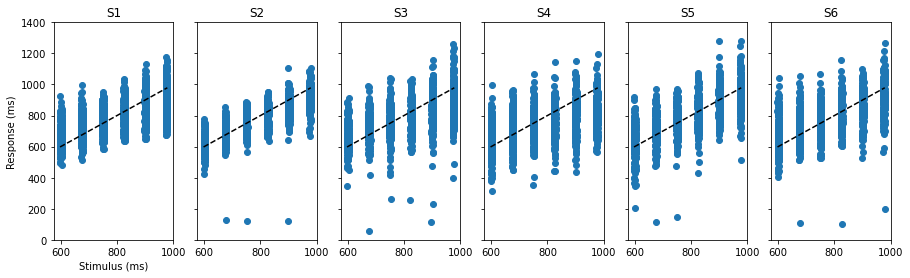

In [2]:
# Code is already provided below, you only need to examine the plots and discuss.
print('a) Reponse plots')

subjects = df['Subject id'].unique()
num_subjects = subjects.shape[0]

fig, axs = plt.subplots(1,num_subjects)
fig.set_size_inches(num_subjects*2.5,4)

def plot_responses(s,r,title='',add_labels=True):
    """Plot the data for a set of stimuli and responses."""
    plt.scatter(s, r,label='data')
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlim((575,1000)) 
    ax.set_ylim((0,1400))
    if add_labels:
        ax.set_xlabel('Stimulus (ms)')
        ax.set_ylabel('Response (ms)')
    else:
        ax.set_yticklabels([])
    # Plot diagonal x-y line, for reference
    axs[index].plot((s.min(),s.max()), (s.min(),s.max()), 'k--')        
    return ax

for index, subject in enumerate(subjects):
    s = df['Stimulus (ms)'][df['Subject id'] == subject]
    r = df['Response (ms)'][df['Subject id'] == subject]
    plt.sca(axs[index])
    plot_responses(s,r,title='S' + str(subject),add_labels=(index==0))    

plt.show()

#### Exercise 4.1a answer

We can see that subjects perform the task with different biases and degrees of accuracy. We also see that most subjects' responses (all but S1) exhibit outliers, likely due to mistakes (called *lapses*, as we will see below).

#### b) Response error/bias plots:

b) Response error/bias plots


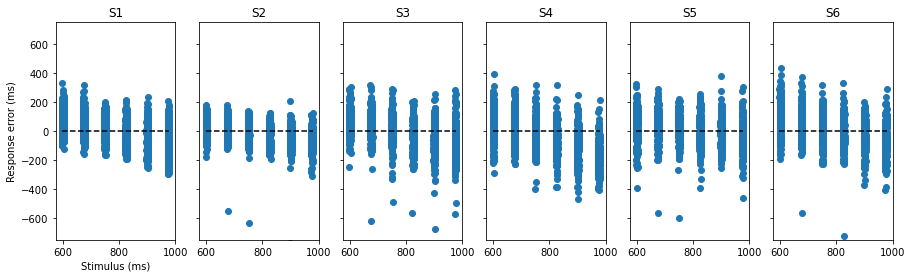

In [3]:
####################################################

print('b) Response error/bias plots')

fig, axs = plt.subplots(1,num_subjects)
fig.set_size_inches(num_subjects*2.5,4)

def plot_bias(s,r,title='',add_labels=True):
    """Plot the data (as error/bias) for a set of stimuli and responses."""
    plt.scatter(s, r-s,label='data')
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlim((575,1000)) 
    ax.set_ylim((-750,750))
    if add_labels:
        ax.set_xlabel('Stimulus (ms)')
        ax.set_ylabel('Response error (ms)')
    else:
        ax.set_yticklabels([])
    plt.plot((s.min(),s.max()), (0.,0.), 'k--')
    return ax

for index, subject in enumerate(subjects):
    s = df['Stimulus (ms)'][df['Subject id'] == subject]
    r = df['Response (ms)'][df['Subject id'] == subject]
    plt.sca(axs[index])
    plot_bias(s,r,title='S' + str(subject),add_labels=(index==0))    
    
plt.show()

#### Exercise 4.1b answer

The response error plot makes very clear that all subjects exhibit the so-called *central tendency* effect: on average, short intervals are overestimated, and long intervals are underestimated, tending towards the center of the distribution of intervals shown in the experiment. The presence (and reason) for this bias should not be surprising.

----------------------------------------------

### The model

We are going to analyze the data with a simple Bayesian observer model, `gaussianobserver`.

- We assume the observer builds a *mismatched* Gaussian prior $p_\text{prior}(s) = \mathcal{N}\left(s| \mu_\text{prior}, \sigma_\text{prior}^2 \right)$ over the stimuli (time intervals). (**Question:** Why we say that this prior is mismatched?)
- We assume that the measurement distribution and likelihood are also Gaussian, $p(x|s) = \mathcal{N}\left(x| s, \sigma^2 \right)$ (we ignore the fact that noise should scale with the interval, which would be more realistic).
- The observer uses the *posterior mean* estimator for the value of the stimulus, $\hat{s}_\text{PM}$ (since the posterior is Gaussian, mean and mode coincide).
- Gaussian motor response noise is added to the estimate, $p(r|\hat{s}) = \mathcal{N}\left(r| \hat{s}, \sigma_\text{motor}^2 \right)$.
- The parameters of this model are $\mathbf{\theta} = \left(\mu_\text{prior}, \sigma_\text{prior}, \sigma, \sigma_\text{motor}\right)$.

We saw in Exercise 3.1 that the response distribution $p(r|s; \mathbf{\theta})$ in this case takes the form:
$$
p(r|s; \theta) = \mathcal{N}\left(r| \mu_\text{resp}, \sigma_\text{resp}^2 \right) \qquad \text{with} \quad
\mu_\text{resp} = ws + (1-w)\mu_\text{prior}, \quad \sigma_\text{resp}^2 = w^2 \sigma^2 + \sigma^2_\text{motor}, \quad w = \frac{\sigma_\text{prior}^2}{\sigma_\text{prior}^2 + \sigma^2}.
$$

*Notes*:
- We used $\mu_\text{prior}$ and $\sigma_\text{prior}$ to denote the mean and standard deviation of the prior. Previously, we used $\mu_s$ and $\sigma_s$, but we use the subscript "prior" here to make it clear that these are properties of the prior distribution and not necessarily of the stimulus distribution, since the two can be different.
- We made explicit the dependence of the response distribution on the model parameters, $p(r|s; \theta)$, which was omitted in the past.

----------------------------------------------

### Exercise 4.2: Plotting the model predictions

> **Motivation:** Whenever you write a model, you should see what the model would predict for reasonable/plausible/typical values of the model parameters. A good thing about normative models is that we can often make (some) predictions *even before seeing the data*. This is true of other models too, but for normative models it is relatively easy to guess reasonable values for the parameters, as they are determined by the task.

Below, we provide code to compute and plot the model predictions for the `gaussianobserver` model.
Our goal here is to plot some sensible predictions for the "typical" observer, characterized by model parameters $\mathbf{\theta}_0$.

- a) Discuss what *a priori* good values for $\mathbf{\theta}_0 = \left(\mu_\text{prior}, \sigma_\text{prior}, \sigma, \sigma_\text{motor}\right)$ would be. Plot example predictions for the dataset of subject 1 with your best guess for the values of $\mathbf{\theta}_0$ (think about it in advance - do not just tweak parameters until you get a good fit!).
- b) Discuss what you see.

*Hints*:
- Think of what $\mu_\text{prior}$ and $\sigma_\text{prior}$ should reasonably be in this scenario, assuming participants have had plenty of practice with the experiment.
- Regarding noise parameters ($\sigma$ and $\sigma_\text{motor}$), remember that timing noise follows *Weber's law* (or the scalar property), that is we expect the noise to be approximately linear in the stimulus value. In the timing domain, the proportionality coefficient $w$ (Weber's fraction) is often in the range $0.05-0.2$.

*Note*: 
- In principle, we could use a *distribution* for $\mathbf{\theta}_0$, but for the scope of this lecture we focus on making predictions from a single parameter vector.


#### Exercise 4.2a answer

Our best guess for sensible a priori starting values could be $\mathbf{\theta}_0 = \left(\mu_\text{prior} = 787.5, \sigma_\text{prior} = 128.1, \sigma = 100, \sigma_\text{motor} = 100 \right)$ ms. 
  - For $\mu_\text{prior}$ and $\sigma_\text{prior}$, it seems sensible as a starting point to use the mean and standard deviation of the experimental distribution of stimuli used in the experiment, assuming the participant has learnt the moments of the distribution of stimuli with practice. For a uniform distribution in the $600-975$ ms interval, these correspond to $\mu_\text{prior} = 787.5$ ms and $\sigma_\text{prior} = 128.1$ ms.
  - For $\sigma$ and $\sigma_\text{motor}$, we assume an average Weber's fraction of $w = 0.125$, somewhere in the middle of the typical range mentioned above of $0.05-0.2$. Since the average stimulus interval in the experiment is $787.5$ ms, we hypothesize an average standard deviation of $787.5 \cdot 0.125 \approx 100$ ms for both sensory and motor noise.
  
We are going to use these values for $\theta_0$ in the code below.

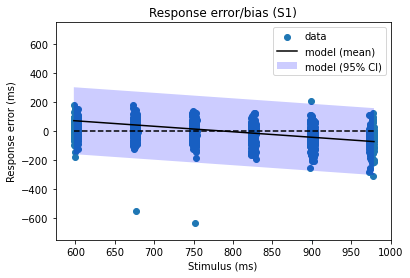

In [4]:
def gaussian_response(s,theta):
    """Compute mean and standard deviation of p(r|s; theta)."""
    # Unpack parameter vector theta
    mu_prior = theta[0]
    sigma_prior = theta[1]
    sigma = theta[2]
    sigma_motor = theta[3]
    # Compute mean and std of the response
    w = sigma_prior**2/(sigma_prior**2 + sigma**2)    
    mu_resp = w*s + (1-w)*mu_prior
    sigma_resp = np.sqrt(w**2*sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

def basicobserver_plot(s,theta):
    """Plot model predictions (mean and 95% confidence interval)."""
    s_range = np.linspace(np.round(s.min()), np.round(s.max()), 200)
    mu_resp, sigma_resp = gaussian_response(s_range,theta)
    bias_resp = mu_resp - s_range    
    ax = plt.gca()
    ax.plot(s_range,bias_resp,'k',label='model (mean)')
    ax.fill_between(s_range, bias_resp - sigma_resp*1.96, bias_resp + sigma_resp*1.96, 
                    facecolor='blue', alpha=0.2, label='model (95% CI)')

subject = 2
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])

# First we plot the data
plot_bias(s,r,'Response error/bias (S1)')

#--------------------------------------------------------------------------
#theta0 = np.array((1000,1000,10,10)) # <-- Change here the model parameters
theta0 = np.array((787.5,128.1,100.,100.))
#--------------------------------------------------------------------------

# Plot the model prediction
basicobserver_plot(s,theta0)
plt.legend()
plt.show()

#### Exercise 4.2b answer

If you have ever run experiments on human participants (good for you if you haven't), this pure prediction in the plot above should strike you as quite good, as it captures to a large extent the bias and variability in the data. 
Of course, the quantitative match is not perfect and we can improve the results by fitting the model parameters to the data. Still, it should be inspiring that we can get very close to what the data will look like even before running the experiment. 

*Note*: Results in cognitive science are not always this promising, so don't get used to this.

### Exercise 4.3: Defining the log-likelihood function

> **Motivation:** As mentioned in the lecture, the log-likelihood function $\log p(\text{data}|\theta, \text{model})$ is the core of statistical model building, and it is essential for model fitting. We write here the log-likelihood for our model of interest.

We recall that the log-likelihood of parameter vector $\mathbf{\theta}$ for a dataset represented by an array of stimuli $\mathbf{s}$ and observed responses $\mathbf{r}$, and a given model (omitted in the following), is:
$$
\log p(\text{data}|\theta) = \log \mathcal{L}(\theta) = \sum_{n = 1}^{N_\text{trials}} \log p(r_n | s_n; \theta)
$$
where $s_n$ and $r_n$ are, respectively, the stimulus and the observed response at the $n$-th trial. (See Section 4.1.1 of the lecture notes.)

For the purpose of this exercise, we consider an ideal Bayesian observer model in which $\mu_\text{prior}$ and $\sigma_\text{prior}$ are fixed to their "true" values ("true" in quotes because the actual stimulus distribution is not Gaussian), that is $\mu_\text{prior} = 787.5$ ms and $\sigma_\text{prior} = 128.1$ ms. Thus, the model has only two free parameters, $\theta = \left(\sigma, \sigma_\text{motor}\right)$. We call this model `idealgaussianobserver`.

- a) Write a Python function that takes as input: an array of model parameters $\mathbf{\theta} = \left(\sigma, \sigma_\text{motor}\right)$, an array of stimuli $\mathbf{s}$ and an array of responses $\mathbf{r}$, and returns the log-likelihood. As mentioned above, assume that $\mu_\text{prior} = 787.5$ ms and $\sigma_\text{prior} = 128.1$ ms are fixed.
- b) As a check, compute the log-likelihood of $\mathbf{\theta}_\text{test} = \left(\sigma = 60, \sigma_\text{motor} = 80 \right)$ ms for dataset S1. You should find $\log \mathcal{L}(\mathbf{\theta}_\text{test}) = -14731.342900471293\ldots$.
- c) Compute the log-likelihood of $\mathbf{\theta}_0$ using the values for $\sigma$ and $\sigma_\text{motor}$ that you hypothesized in Exercise 4.2. Do your hypothesized values yield a better (higher) value of the log-likelihood?

*Hints*:
To write the log-likelihood function:
   1. First, get $\mu_\text{resp}$ and $\sigma_\text{resp}$, the mean and standard deviation of the response distribution, for an arbitrary vector $\mathbf{s}$ of stimuli (use the function `gaussian_response` defined in Exercise 4.2). 
   2. Then, compute the log-likelihood for each trial, $\log p(r_n|s_n; \mathbf{\theta})$, for vectors $\mathbf{s}$ of stimuli and $\mathbf{r}$ of responses. Calculate the log-likelihood per trial in a vectorized way (i.e., no loops!). 
     - You can use `scipy.stats.norm.logpdf`, which returns the logarithm of the pdf of a normal distribution. Do not compute the logarithm by naively applying `np.log` to `scipy.stats.norm.pdf` (why?).
   4. Finally, sum the log-likelihood of each trial.

In [5]:
# a)

def idealgaussianobserver_loglike(theta,s_vec,r_vec):
    """Log-likelihood of ideal Gaussian observer model."""
    mu_prior = 787.5
    sigma_prior = 128.1
    sigma = theta[0]
    sigma_motor = theta[1] 
    mu_resp, sigma_resp = gaussian_response(s_vec,np.array((mu_prior,sigma_prior,sigma,sigma_motor)))
    loglike_vec = sps.norm.logpdf(r_vec,mu_resp,sigma_resp) # Vector of log-likelihood per trials
    loglike = np.sum(loglike_vec) # Total log-likelihood
    return loglike

subject = 2
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])

theta_test = np.array((90.,60.))
loglike_test = idealgaussianobserver_loglike(theta_test,s,r)
print('b) The log-likelihood of theta_test = {} (dataset S{}) is: {}'.format(
    theta_test, subject, loglike_test))

loglike0 = idealgaussianobserver_loglike(theta0[2:4],s,r)
print('c) The log-likelihood of theta_0 = {} (dataset S{}) is: {}'.format(
    theta0[2:4], subject, loglike0))

b) The log-likelihood of theta_test = [90. 60.] (dataset S2) is: -8624.59605667031
c) The log-likelihood of theta_0 = [100. 100.] (dataset S2) is: -8880.130260794816


### Exercise 4.4: Maximum-likelihood estimation of model parameters

> **Motivation:** Model fitting is an essential part of computational modelling - we want to fit our models to the experimental data. In statistical terminology, we are *estimating* the model parameters based on the data. There are many ways to fit models, in this course we largely stick to the common approach of *maximum-likelihood estimation*.

In this exercise, we are going to estimate model parameters (aka fit our models) by maximizing the log-likelihood. By convention in optimization, we will have to minimize the *negative* log-likelihood. See Section 4.1.2 of the lecture notes.

- a) **Set up the optimization**: Before running the optimization, we need to do some bookkeeping. 
  - First, define the *target* (or objective) function for the optimization, the negative log-likelihood for parameters and a fixed dataset. In this exercise, we keep using the data from S1. *Hint*: You can use `negf = lambda x: -f(x)` to define a function `negf` that returns the negative of what `f` returns.
  - Second, define the *hard* lower and upper bounds for the parameters (`lower_bounds` and `upper_bounds`). If the optimization algorithm supports constrained (bound) optimization, it will never go outside the hard bounds. We also recommend to define the *plausible* bounds, as the range of parameters that we would expect to see. We are going to use the plausible range to initialize the problem later.
- b) **Run the optimization**: Run the optimization *multiple times* (e.g., at least three times, the more the better), from different starting points, and take the result with the lowest negative log-likelihood (highest log-likelihood) as the maximum-likelihood estimate $\hat{\theta}_\text{ML}$. (**Question:** Why do we need multiple runs?)
  - For each optimization run, you can start from a random point drawn uniformly from within the *plausible range*. As a suggestion, pick the very first point equal to the mean of the plausible range; then pick the other ones randomly. (You can also use other strategies for choosing initial points for the optimization.)
  - You are free to use any optimizer of your choice. If in doubt, the optimization methods in `scipy.optimize.minimize` are often a good choice, in particular `L-BFGS-B`. You can set up and perfom a bounded optimization run using:
  ```
  bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
  res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
  ```
  where `target_fun` is the target function for the optimization (i.e., the negative log-likelihood), and `theta0` is the starting point for this run of the optimization.
  - How does the optimum value of the log-likelihood compare to what you found in the previous exercise?
- c) **Visualize the results**: Plot the prediction of the maximum-likelihood solution, $\hat{\theta}_\text{ML}$, on top of the data (use code from Exercise 4.2).

#### a) Set up the optimization:

In [6]:
# Define the target function: negative log-likelihood with subject 1 dataset
subject = 1
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])
target_fun = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s,r)

# Define hard parameter bounds
#lower_bounds = np.array([0.,0.]) # <--- Write the lower bounds
#upper_bounds = np.array([np.inf,np.inf]) # <--- Write the upper bounds
lower_bounds = np.array([1.,1.])
upper_bounds = np.array([2000.,2000.])

print('Hard lower bounds: {}'.format(lower_bounds))
print('Hard upper bounds: {}'.format(upper_bounds))

# Define plausible range
#plausible_lower_bounds = np.array([0.,0.]) # <--- Write plausible lower bounds
#plausible_upper_bounds = np.array([np.inf,np.inf])  # <--- Write plausible upper bounds
plausible_lower_bounds = np.array([np.mean(s)*0.05,np.mean(s)*0.05])
plausible_upper_bounds = np.array([np.mean(s)*0.20,np.mean(s)*0.20])

print('Plausible lower bounds: {}'.format(plausible_lower_bounds))
print('Plausible upper bounds: {}'.format(plausible_upper_bounds))

Hard lower bounds: [1. 1.]
Hard upper bounds: [2000. 2000.]
Plausible lower bounds: [39.40988941 39.40988941]
Plausible upper bounds: [157.63955762 157.63955762]


#### b) Run the optimization:

In [7]:
num_runs = 3

def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs=3):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)    
        bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
        res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
        nll_res[index] = res.fun
        theta_res[index] = res.x
        print('Run {}: log-likelihood {}'.format(index, -res.fun))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best

nll_best,theta_best = multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs)
print('The maximum-likelihood solution (dataset S{}) is theta_ML = {} with log-likelihood: {}'.format(
    subject, theta_best, -nll_best))

print('For comparison, the log-likelihood of theta_test = {} (dataset S{}) was: {}'.format(
    theta_test, subject, loglike_test))


Run 0: log-likelihood -14497.354655718349
Run 1: log-likelihood -14497.354656263044
Run 2: log-likelihood -14497.354655726122
The maximum-likelihood solution (dataset S1) is theta_ML = [109.59521444  42.5383628 ] with log-likelihood: -14497.354655718349
For comparison, the log-likelihood of theta_test = [60. 80.] (dataset S1) was: -14731.342900471293


#### c) Visualize the results:

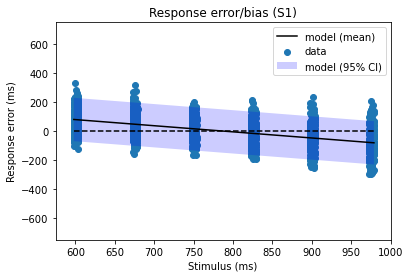

In [8]:
plot_bias(s,r,'Response error/bias (S1)')

theta4_best = np.array((787.5,128.1,theta_best[0],theta_best[1]))
basicobserver_plot(s,theta4_best)
plt.legend()
plt.show()

### Exercise 4.5: Lapses

> **Motivation:** Human and animal subjects often behave unpredictably - sometimes simply due to mistakes. These mistakes appear as outliers in the behavioral responses measured in an experiment. A principled way to deal with such outlier responses is to introduce a "lapse" component in the observer model.

In this exercise, we add a "lapse" component to the `idealgaussianobserver` model. We assume that in each trial there is a probability $\lambda \in [0, 1]$ (the *lapse rate*) that the observer ignores the stimulus and instead responds randomly from a fixed lapse distribution $p_\text{lapse}(r)$ (see Section 4.3 of the lecture notes).

That is, the modified response distribution for this model with lapse is:
$$
p_\text{resp-with-lapse}(r|s,\theta) = (1-\lambda) p_\text{resp}(r|s,\theta) + \lambda p_\text{lapse}(r),
$$
where $p_\text{resp}(r|s,\theta)$ is the same as the `idealgaussianobserver` model (without lapse), and $p_\text{lapse}(r)$ represents the lapse distribution.

For this scenario, we assume a uniform lapse distribution $p_\text{lapse}(r) = \text{Uniform}\left(0, 2000\right)$ ms.

The `idealgaussianobserverwithlapse` model has thus three parameters, $\theta = (\sigma, \sigma_\text{motor}, \lambda)$. 

- a) Write the log-likelihood function for the model `idealgaussianobserverwithlapse`.
- b) Evaluate the log-likelihood of the dataset of subject S1 at $\theta_1 = (\sigma = 100, \sigma_\text{motor} = 80, \lambda = 0)$ and $\theta_2 = (\sigma = 100, \sigma_\text{motor} = 80, \lambda = 0)$. What do you observe, and how do you interpret the results?
- c) Evaluate the log-likelihood of the dataset of subject S3 at $\theta_1 = (\sigma = 100, \sigma_\text{motor} = 80, \lambda = 0)$ and $\theta_2 = (\sigma = 100, \sigma_\text{motor} = 80, \lambda = 0)$. What do you observe, and how do you interpret the results?

*Hints*:
- To avoid numerical issues for extreme values, you might want to use the [logsumexp trick](https://www.cs.helsinki.fi/u/ahonkela/teaching/compstats1/book/numerical-mathematics.html#computing-with-probabilities) when computing the response distribution with lapses; but it is not strictly needed here.
- To make sense of questions (b) and (c), you may want to have a look at the datasets, as plotted in Exercise 4.1.

In [9]:
def idealgaussianobserverwithlapse_loglike(theta,s_vec,r_vec):
    """Log-likelihood of ideal Gaussian observer with added lapse."""
    mu_prior = 787.5
    sigma_prior = 128.1
    sigma = theta[0]
    sigma_motor = theta[1]
    lapse_rate = theta[2]
    lapse_pdf = 1/2000.
    mu_resp, sigma_resp = gaussian_response(s_vec,np.array((mu_prior,sigma_prior,sigma,sigma_motor)))
    # First, compute log-likelihood without probability of lapse
    loglike_vec = sps.norm.logpdf(r_vec,mu_resp,sigma_resp) # Vector of log-likelihood per trials
    # Now, add the probability of lapse
    if lapse_rate > 0.:
        likelihood_vec = np.exp(loglike_vec) # Exponentiate back to the likelihood
        likelihood_with_lapse_vec = (1-lapse_rate)*likelihood_vec + lapse_rate*lapse_pdf
        loglike_vec = np.log(likelihood_with_lapse_vec)
        # This code snippet below uses the logsumexp trick, which is numerically more stable
        # loglapse = np.log(lapse_rate*lapse_pdf)
        # M = np.maximum(loglike, loglapse)
        # loglike = np.log((1-lapse_rate)*np.exp(loglike-M) + np.exp(loglapse-M)) + M        
    return np.sum(loglike_vec)

theta1 = (100,80,0)
theta2 = (100,80,0.05)

print('b)')

subject = 1
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])
loglike1 = idealgaussianobserverwithlapse_loglike(theta1,s,r)
loglike2 = idealgaussianobserverwithlapse_loglike(theta2,s,r)
print('The log-likelihood of theta_1 = {} (dataset S{}) is: {}'.format(
    theta1, subject, loglike1))
print('The log-likelihood of theta_2 = {} (dataset S{}) is: {}'.format(
    theta2, subject, loglike2))

###################################################################

print('c)')

subject = 3
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])
loglike1 = idealgaussianobserverwithlapse_loglike(theta1,s,r)
loglike2 = idealgaussianobserverwithlapse_loglike(theta2,s,r)
print('The log-likelihood of theta_1 = {} (dataset S{}) is: {}'.format(
    theta1, subject, loglike1))
print('The log-likelihood of theta_2 = {} (dataset S{}) is: {}'.format(
    theta2, subject, loglike2))


b)
The log-likelihood of theta_1 = (100, 80, 0) (dataset S1) is: -14670.990130532295
The log-likelihood of theta_2 = (100, 80, 0.05) (dataset S1) is: -14774.53280426473
c)
The log-likelihood of theta_1 = (100, 80, 0) (dataset S3) is: -9258.734383166793
The log-likelihood of theta_2 = (100, 80, 0.05) (dataset S3) is: -9225.199666345636


#### Answers:

- b) Here the log-likelihood for $\theta_1$ is slightly higher (a few points) than the log-likelihood for $\theta_2$. This suggests that a zero-lapse parameter may be better here. This intuition matches with the data of S1, which shows no outliers.
- c) Here the log-likelihood for $\theta_2$ is way higher (dozens of points) than the log-likelihood for $\theta_1$. This suggests that having a non-zero lapse parameter may be better here. This intuition matches with the data of S3, which shows several outlier responses.

### Exercise 4.6: Model comparison

> **Motivation:** Cognitive modelling often involves comparing different hypotheses about the observers, represented by different models. We can quantify this with formal metrics of model comparison. Here we see whether adding "lapses" improves our models from the previous sections.

In this exercise, we look at model comparison (see Section 4.2 of the lecture notes and Section C.5.3 of \[**MKG22**\]).
We compare here the `idealgaussianobserver` model from Exercise 4.3 and the `idealgaussianobserverwithlapse` from Exercise 4.5. We will make more formally the observations you may have had in the previous exercise.

- a) Compute the maximum-likelihood solution for the `idealgaussianobserverwithlapse` model, applied to dataset S1.
- b) Compare the `idealgaussianobserver` and `idealgaussianobserverwithlapse` models applied to dataset S1 according to the log-likelihood, Akaike's Information Criterion (AIC), and the so-called Bayesian Information Criterion (BIC). Which model is best according to these metrics? Discuss your findings.
- c) Repeat the same comparison but for dataset S3. Which model is best according to these metrics? Discuss your findings.

#### a) Maximum-likelihood solution for the `idealgaussianobserverwithlapse` (for S1)

In [10]:
# Define the target function: negative log-likelihood with subject 1 dataset
subject = 1
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])
target_fun = lambda theta_: -idealgaussianobserverwithlapse_loglike(np.array(theta_),s,r)

# Define hard parameter bounds and plausible range
lower_bounds = np.array([1.,1.,0.])
upper_bounds = np.array([2000.,2000.,1.])
plausible_lower_bounds = np.array([np.mean(s)*0.05,np.mean(s)*0.05,0.01])
plausible_upper_bounds = np.array([np.mean(s)*0.20,np.mean(s)*0.20,0.05])

nll2_best,theta2_best = multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs)
print('The maximum-likelihood solution is theta_ML = {} with log-likelihood: {}'.format(theta2_best, -nll2_best))

Run 0: log-likelihood -14497.354655745843
Run 1: log-likelihood -14497.354655865245
Run 2: log-likelihood -14497.35465568606
The maximum-likelihood solution is theta_ML = [109.59598045  42.53772903   0.        ] with log-likelihood: -14497.35465568606


#### b) Comparison of `idealgaussianobserver` and `idealgaussianobserverwithlapse` models (for S1)

In [11]:
num_params = np.array((np.shape(theta_best)[0],np.shape(theta2_best)[0]))
num_trials = np.shape(s)[0]

nll = np.array([nll_best, nll2_best])
aic = 2*nll + 2*num_params
bic = 2*nll + num_params*np.log(num_trials)

print('Model comparison results (for all metrics, lower is better)\n')
print('Negative log-likelihoods: ' + str(nll))
print('AIC: ' + str(aic))
print('BIC: ' + str(bic))

Model comparison results (for all metrics, lower is better)

Negative log-likelihoods: [14497.35465572 14497.35465569]
AIC: [28998.70931144 29000.70931137]
BIC: [29010.3733398  29018.20535391]


#### Answer

The best model describing S1, according to the model comparison metrics (lower is better), is `idealgaussianobserver`. As we saw in Exercise 1, the responses of S1 show no outliers or lapses, so the lapse rate in the `idealgaussianobserverwithlapse` model ends up being $\hat{\lambda}_\text{MLE} = 0$, bringing no contribution to the model.

#### c) Comparison of `idealgaussianobserver` and `idealgaussianobserverwithlapse` models (for S3)

In [12]:
subject = 3
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])

target_fun = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s,r)

# Define hard parameter bounds and plausible range
lower_bounds = np.array([1.,1.])
upper_bounds = np.array([2000.,2000.])
plausible_lower_bounds = np.array([np.mean(s)*0.05,np.mean(s)*0.05])
plausible_upper_bounds = np.array([np.mean(s)*0.20,np.mean(s)*0.20])

print('Optimize idealgaussianobserver model...')
nll_best,theta_best = multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs)
print('The maximum-likelihood solution is theta_ML = {} with log-likelihood: {}'.format(theta_best, -nll_best))

# Define the target function: negative log-likelihood with subject 1 dataset
target_fun = lambda theta_: -idealgaussianobserverwithlapse_loglike(np.array(theta_),s,r)

# Define hard parameter bounds and plausible range
lower_bounds = np.array([1.,1.,0.])
upper_bounds = np.array([2000.,2000.,1.])
plausible_lower_bounds = np.array([np.mean(s)*0.05,np.mean(s)*0.05,0.01])
plausible_upper_bounds = np.array([np.mean(s)*0.20,np.mean(s)*0.20,0.05])

print('Optimize idealgaussianobserverwithlapse model...')
nll2_best,theta2_best = multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs)
print('The maximum-likelihood solution is theta_ML = {} with log-likelihood: {}'.format(theta2_best, -nll2_best))

num_params = np.array((np.shape(theta_best)[0],np.shape(theta2_best)[0]))
num_trials = np.shape(s)[0]

nll = np.array([nll_best, nll2_best])
aic = 2*nll + 2*num_params
bic = 2*nll + num_params*np.log(num_trials)

print('Model comparison results (for all metrics, lower is better)\n')
print('Negative log-likelihoods: ' + str(nll))
print('AIC: ' + str(aic))
print('BIC: ' + str(bic))

Optimize idealgaussianobserver model...
Run 0: log-likelihood -9248.926314421056
Run 1: log-likelihood -9248.926314419366
Run 2: log-likelihood -9248.926314430008
The maximum-likelihood solution is theta_ML = [116.68945574  84.46390756] with log-likelihood: -9248.926314419366
Optimize idealgaussianobserverwithlapse model...
Run 0: log-likelihood -9189.579793833651
Run 1: log-likelihood -9189.579794335728
Run 2: log-likelihood -9189.579793966861
The maximum-likelihood solution is theta_ML = [1.15420720e+02 7.30959792e+01 9.73122669e-03] with log-likelihood: -9189.579793833651
Model comparison results (for all metrics, lower is better)

Negative log-likelihoods: [9248.92631442 9189.57979383]
AIC: [18501.85262884 18385.15958767]
BIC: [18512.50687542 18401.14095754]


#### Answer

By looking at the data of S3, we can see many outliers. Indeed, the `idealgaussianobserverwithlapse` model performs substantially better in terms of metrics, and it finds a small but nonzero lapse $\hat{\lambda}_\text{MLE} \approx 0.01$ (which represents a $\approx 1\%$ probability of lapsing for S3).